In [2]:
import importlib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import json
import sys
import statsmodels.api as sm
import os
from tensorflow import keras
from tensorflow.keras import layers

import kad.visualization.visualization as visualization
from kad.kad_utils import kad_utils
from kad.kad_utils.kad_utils import customize_matplotlib
import kad.model.autoencoder_model as autoencoder_model
from kad.model.sarima_model import SarimaModel
import kad.models_evaluation.models_evaluator as models_evaluator

sys.path.insert(1, '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector')
print(sys.path)

import kad.ts_analyzer.ts_analyzer as ts_analyzer
from kad.model import i_model
from sklearn.model_selection import train_test_split

customize_matplotlib()

['/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector/notebooks', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector/venv/lib/python3.8/site-packages', '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector/venv/lib/python3.8/site-packages/IPython/extensions', '/home/maciek/.ipython', '/snap/pycharm-professional/248/plugins/python/helpers/pydev', '/snap/pycharm-professional/248/plugins/python/helpers-pro/jupyter_debug']


In [3]:
data_dir = "data/archive/"
file_dir = "artificialWithAnomaly"
file_name = "artificialWithAnomaly/art_daily_jumpsup.csv"
# file_name = "artificialWithAnomaly/art_daily_flatmiddle.csv"

file_path = os.path.join(data_dir, file_dir, file_name)

original_df = pd.read_csv(
    file_path, parse_dates=True, index_col="timestamp"
)

# original_df = original_df.resample("h").agg(np.mean)
original_df = original_df.rolling("2h").sum()

with open("data/archive/combined_windows.json") as f:
    true_anomalies = json.load(f)

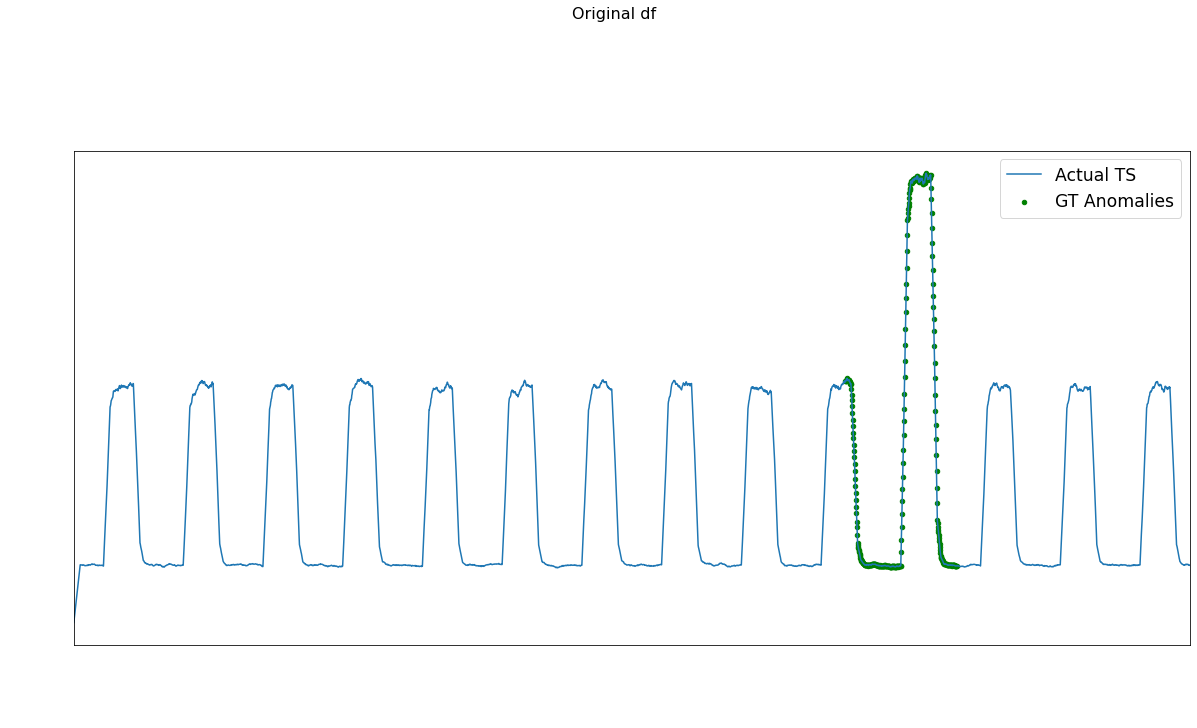

In [4]:
X_LABEL = "timestamp"
ts_analyzer = importlib.reload(ts_analyzer)

true_anomalies_ranges = true_anomalies[file_name]

ground_true_anomalies_df = pd.DataFrame()
for anom_range in true_anomalies_ranges:
    ground_true_anomalies_df = ground_true_anomalies_df.append(original_df.loc[anom_range[0]:anom_range[1]])

# ground_true_anomalies_df = ground_true_anomalies_df[int(-3/4*len(ground_true_anomalies_df)):int(3/4*len(ground_true_anomalies_df))]

preprocessed_df = original_df.copy()
preprocessed_df[kad_utils.GROUND_TRUTH_COLUMN] = [idx in ground_true_anomalies_df.index for idx in original_df.index.tolist()]

visualization.visualize(results_df=preprocessed_df, metric_name="value", title="Original df")

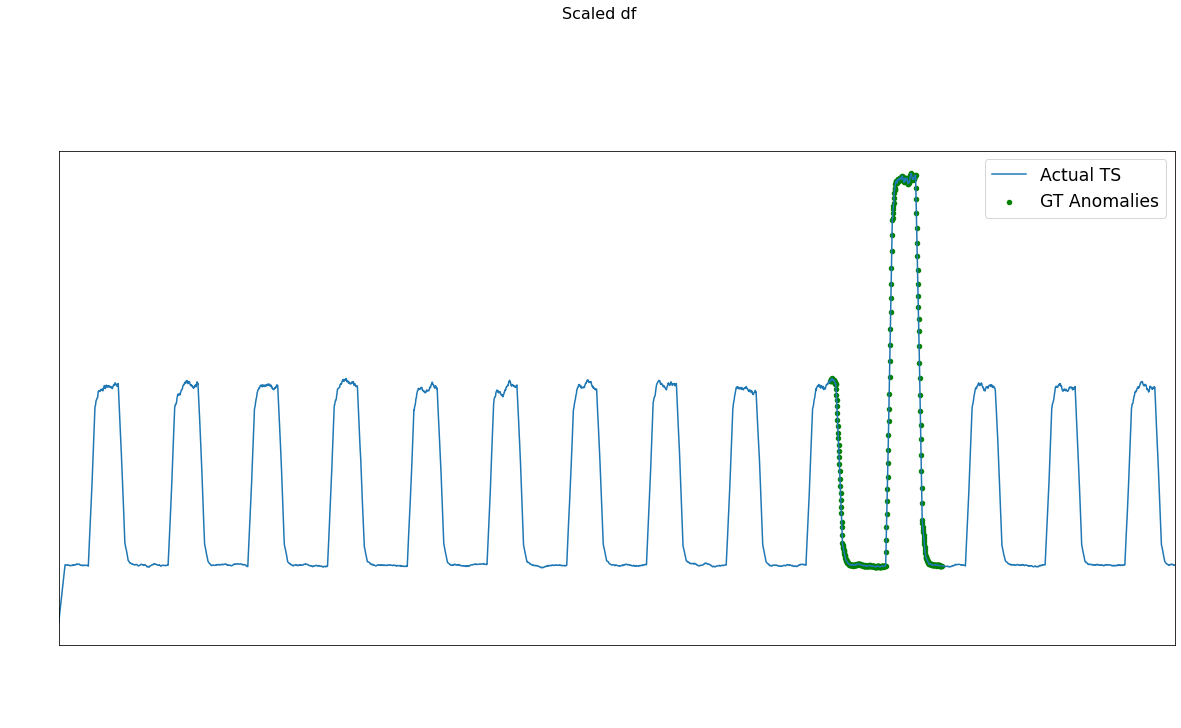

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
# scaler = StandardScaler()
preprocessed_df["value"] = scaler.fit_transform(preprocessed_df.values)

visualization.visualize(results_df=preprocessed_df, metric_name="value", title="Scaled df")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 12, 128)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 12, 128)           131584    
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 128)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 12, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
________________________________________________

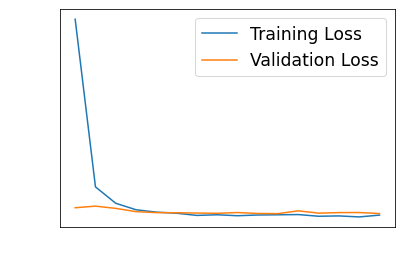

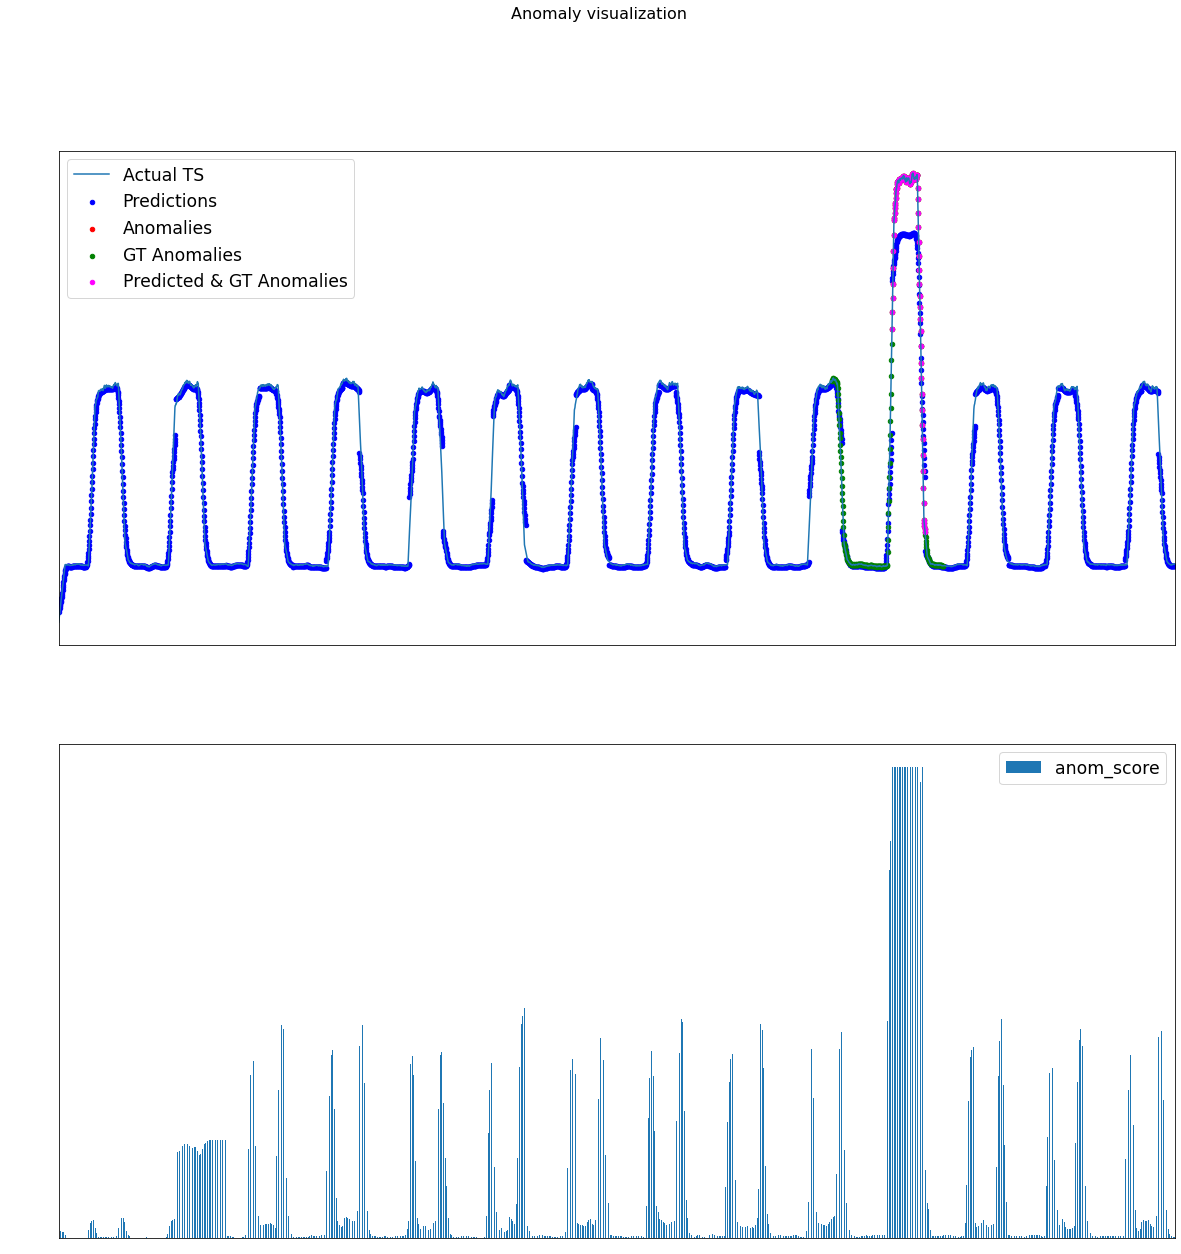

In [7]:
autoencoder_model = importlib.reload(autoencoder_model)

model: i_model.IModel = autoencoder_model.AutoEncoderModel(time_steps=12)

values_df = preprocessed_df[["value"]]
train_df, test_df = train_test_split(values_df, shuffle=False, train_size=0.15)
val_err = model.train(train_df)

results_df = pd.DataFrame()
SAMPLES_TO_PREDICT = 60
for i in range(0, len(test_df), SAMPLES_TO_PREDICT):
    if len(test_df.iloc[i:i + SAMPLES_TO_PREDICT]) < SAMPLES_TO_PREDICT:
        break
    results_df = model.test(test_df.iloc[i:i + SAMPLES_TO_PREDICT])

evaluation_df = results_df.copy()
evaluation_df[kad_utils.GROUND_TRUTH_COLUMN] = preprocessed_df[kad_utils.GROUND_TRUTH_COLUMN]
visualization.visualize(evaluation_df, "value")

<ipython-input-8-1719a12e1e72>:1: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  final_df = evaluation_df.loc[test_df.index & evaluation_df.index]


Accuracy:  0.92
Avg precision:  0.45
Recall:  0.3


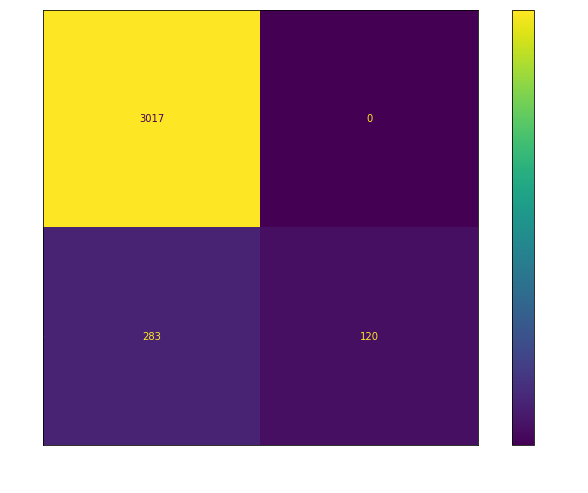

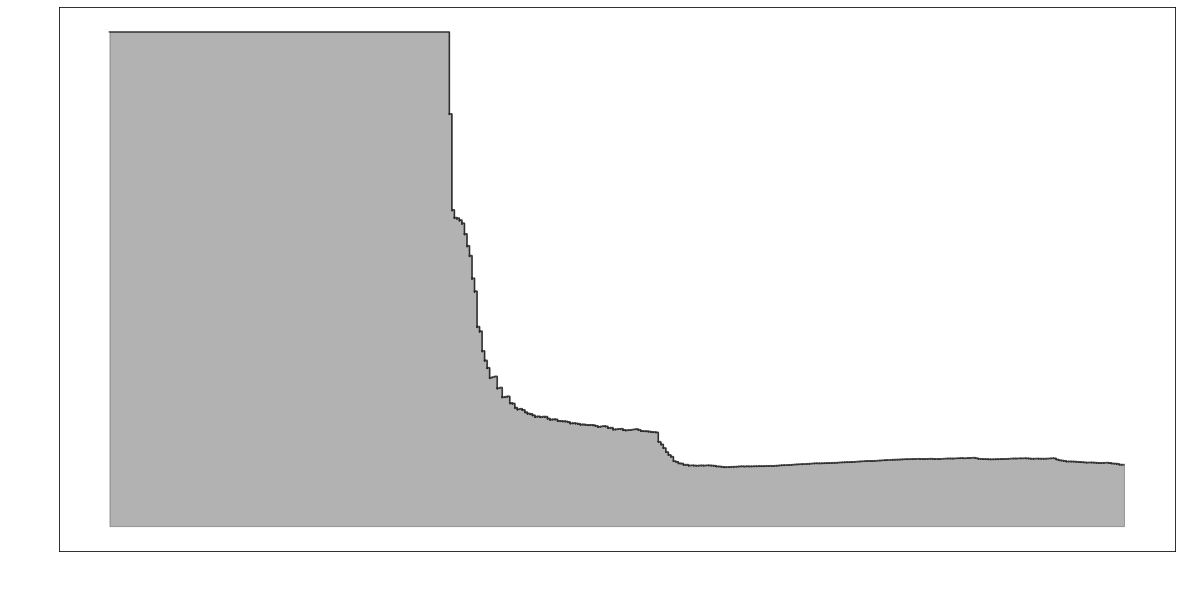

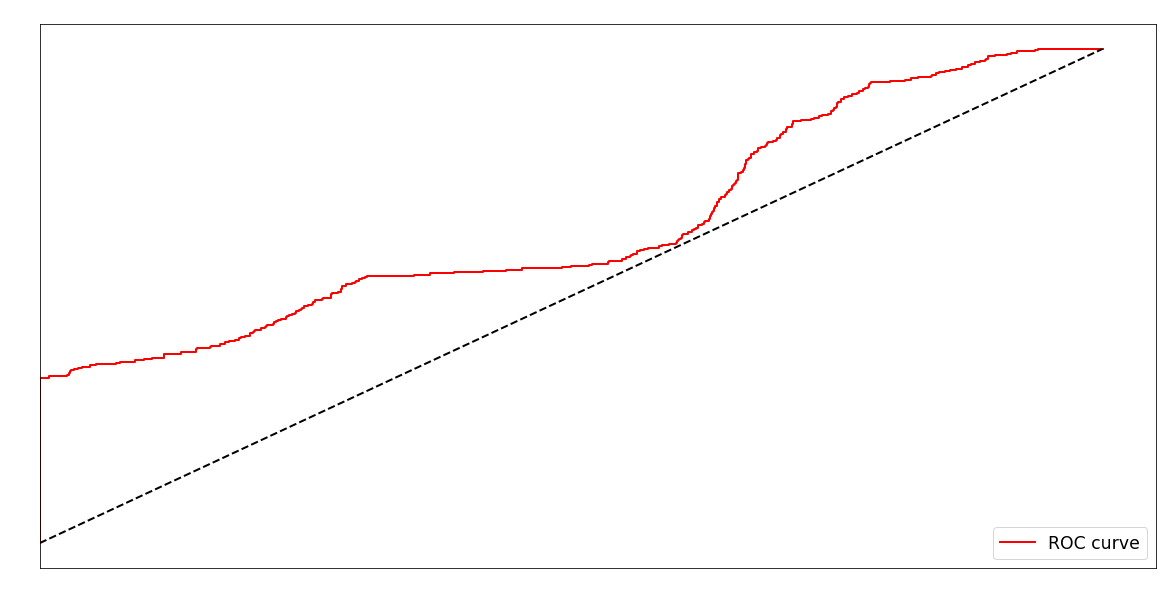

In [8]:
final_df = evaluation_df.loc[test_df.index & evaluation_df.index]
evaluator = models_evaluator.ModelsEvaluator(df=final_df)

print("Accuracy: ", evaluator.get_accuracy())
print("Avg precision: ", evaluator.get_average_precision())
print("Recall: ", evaluator.get_recall_score())

evaluator.plot_confusion_matrix()

evaluator.plot_precision_recall_curve()
evaluator.plot_roc()
